# Linear Regression with California Housing Data

This notebook implements linear regression using Gradient Descent and Stochastic Gradient Descent.
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from io import StringIO
import pandas as pd

In [2]:
def load_california_housing_data():

  url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
  print("Downloading and processing California Housing dataset with pandas...")
  df = pd.read_csv(url)
  df_filtered = df[['median_income', 'median_house_value']].copy()
  df_filtered.dropna(inplace=True)
  df_filtered = df_filtered[
        (df_filtered['median_income'] >= 0.5) & (df_filtered['median_income'] <= 15) &
        (df_filtered['median_house_value'] >= 15000) & (df_filtered['median_house_value'] <= 500000)
    ]
  X = df_filtered['median_income'].values
  y = df_filtered['median_house_value'].values
  return X, y, "California Housing Dataset", "Median Income (10k$)", "House Value"

In [3]:
#Data Preprocessing

def preprocess_data(X, y):
    """
    Preprocesses the data for better gradient descent performance.
    """
    #standardization
    X_mean, X_std = np.mean(X), np.std(X)
    X_scaled = (X - X_mean) / X_std

    #Target scaling
    y_mean, y_std = np.mean(y), np.std(y)
    y_scaled = (y - y_mean) / y_std

    return X_scaled, y_scaled, (X_mean, X_std), (y_mean, y_std)

def unscale_parameters(m_scaled, c_scaled, X_stats, y_stats):
    X_mean, X_std = X_stats
    y_mean, y_std = y_stats

    #Convert back to original scale
    m_original = m_scaled * (y_std / X_std)
    c_original = y_mean + c_scaled * y_std - m_original * X_mean

    return m_original, c_original


In [ ]:
#Core Functions
def predict(X, m, c):
    "Makes predictions for y based on X, m, and c."
    return m * X + c

def calculate_mse(y_true, y_pred):
    "Calculates the Mean Squared Error (cost)."
    return np.mean((y_true - y_pred) ** 2)

def calculate_r_squared(y_true, y_pred):
    "Calculates R-squared."
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


In [ ]:
#Gradient Descent Implementation

class GradientDescentFitter:
    """
    Fits a linear regression model using batch Gradient Descent.
    """
    def __init__(self, learning_rate=0.01, epochs=1000, tolerance=1e-8):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tolerance = tolerance
        self.m = None
        self.c = None
        self.cost_history = []
        self.training_time = 0

    def fit(self, X, y):
        self.m, self.c = 0.0, 0.0  # Initialize parameters
        self.cost_history = []

        start_time = time.time()

        for epoch in range(self.epochs):
            # Make predictions
            y_pred = self.predict(X)

            # Calculate error
            error = y_pred - y

            # Calculate gradients (vectorized)
            gradient_m = (2 / len(X)) * np.sum(error * X)
            gradient_c = (2 / len(X)) * np.sum(error)

            # Update parameters
            self.m = self.m - self.learning_rate * gradient_m
            self.c = self.c - self.learning_rate * gradient_c

            # Calculate cost
            cost = calculate_mse(y, y_pred)
            self.cost_history.append(cost)

            # Early stopping
            if len(self.cost_history) > 1 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

        self.training_time = time.time() - start_time
        return self

    def predict(self, X):
        """Makes predictions for y based on X and current model parameters."""
        return self.m * X + self.c

In [6]:
#Stochastic Gradient Descent Implementation

class StochasticGradientDescentFitter:
    """
    Fits a linear regression model using Stochastic Gradient Descent.
    """
    def __init__(self, learning_rate=0.01, epochs=1000, tolerance=1e-8):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tolerance = tolerance
        self.m = None
        self.c = None
        self.cost_history = []
        self.training_time = 0

    def fit(self, X, y):
        self.m, self.c = 0.0, 0.0  # Initialize parameters
        self.cost_history = []

        start_time = time.time()
        data = list(zip(X, y))

        for epoch in range(self.epochs):
            # Shuffle data at the start of each epoch
            random.shuffle(data)

            for xi, yi in data:
                # Single point prediction
                y_pred = self.predict(xi)
                error = y_pred - yi

                # Single point gradients
                gradient_m = 2 * error * xi
                gradient_c = 2 * error

                # Update parameters
                self.m = self.m - self.learning_rate * gradient_m
                self.c = self.c - self.learning_rate * gradient_c

            # Calculate epoch cost on entire dataset
            epoch_pred = self.predict(X)
            cost = calculate_mse(y, epoch_pred)
            self.cost_history.append(cost)

            # Early stopping
            if len(self.cost_history) > 10 and abs(np.mean(self.cost_history[-10:-5]) - np.mean(self.cost_history[-5:])) < self.tolerance:
                print(f"  Early stopping at epoch {epoch + 1}")
                break

        self.training_time = time.time() - start_time
        return self

    def predict(self, X):
        """Makes predictions for y based on X and current model parameters."""
        return self.m * X + self.c

In [7]:
#Load and Prepare Dataset

# Load dataset
X_raw, y_raw, dataset_name, x_label, y_label = load_california_housing_data()

# Preprocess data
X, y, X_stats, y_stats = preprocess_data(X_raw, y_raw)

# Split into train/test (simple split for demonstration)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]


print(f"\nDataset: {dataset_name}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")



Dataset: California Housing Dataset
Training samples: 15726
Test samples: 3932


In [8]:
#Model Training

# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 2000

print(f"\nTraining with Learning Rate: {LEARNING_RATE} and Epochs: {EPOCHS}")

# Run Gradient Descent
print(f"\nRunning Gradient Descent...")
gd_fitter = GradientDescentFitter(learning_rate=LEARNING_RATE, epochs=EPOCHS)
gd_fitter.fit(X_train, y_train)

# Run Stochastic Gradient Descent
print(f"Running Stochastic Gradient Descent...")
sgd_fitter = StochasticGradientDescentFitter(learning_rate=LEARNING_RATE, epochs=EPOCHS)
sgd_fitter.fit(X_train, y_train)

print("Models trained.")


Training with Learning Rate: 0.01 and Epochs: 2000

Running Gradient Descent...
  Early stopping at epoch 356
Running Stochastic Gradient Descent...
Models trained.


In [9]:
#Model Evaluation

# Convert parameters back to original scale
gd_m_orig, gd_c_orig = unscale_parameters(gd_fitter.m, gd_fitter.c, X_stats, y_stats)
sgd_m_orig, sgd_c_orig = unscale_parameters(sgd_fitter.m, sgd_fitter.c, X_stats, y_stats)

# Make predictions on test set
X_test_pred_gd = gd_fitter.predict(X_test)
X_test_pred_sgd = sgd_fitter.predict(X_test)

# Calculate performance metrics
gd_test_mse = calculate_mse(y_test, X_test_pred_gd)
sgd_test_mse = calculate_mse(y_test, X_test_pred_sgd)
gd_r2 = calculate_r_squared(y_test, X_test_pred_gd)
sgd_r2 = calculate_r_squared(y_test, X_test_pred_sgd)

# Results
print("\n" + "="*30)
print("RESULTS")
print("="*30)
print(f"GRADIENT DESCENT:")
print(f"   m = {gd_m_orig:.2f}, c = {gd_c_orig:.2f}")
print(f"   Test MSE:      {gd_test_mse:.6f}")
print(f"   R² Score:      {gd_r2:.4f}")
print(f"   Time:        {gd_fitter.training_time:.4f}s")

print(f"\nSTOCHASTIC GRADIENT DESCENT:")
print(f"   m = {sgd_m_orig:.2f}, c = {sgd_c_orig:.2f}")
print(f"   Test MSE:      {sgd_test_mse:.6f}")
print(f"   R² Score:      {sgd_r2:.4f}")
print(f"   Time:        {sgd_fitter.training_time:.4f}s")

# Interpretation of slope (original scale)
print(f"\nInterpretation:")
print(f"   For every additional $10k in median income, the house value increases by ~${(gd_m_orig + sgd_m_orig)/2:,.0f}.")


RESULTS
GRADIENT DESCENT:
   m = 38764.58, c = 48014.10
   Test MSE:      0.603255
   R² Score:      0.4500
   Time:        0.0441s

STOCHASTIC GRADIENT DESCENT:
   m = 37496.75, c = 54409.66
   Test MSE:      0.605000
   R² Score:      0.4485
   Time:        32.9512s

Interpretation:
   For every additional $10k in median income, the house value increases by ~$38,131.


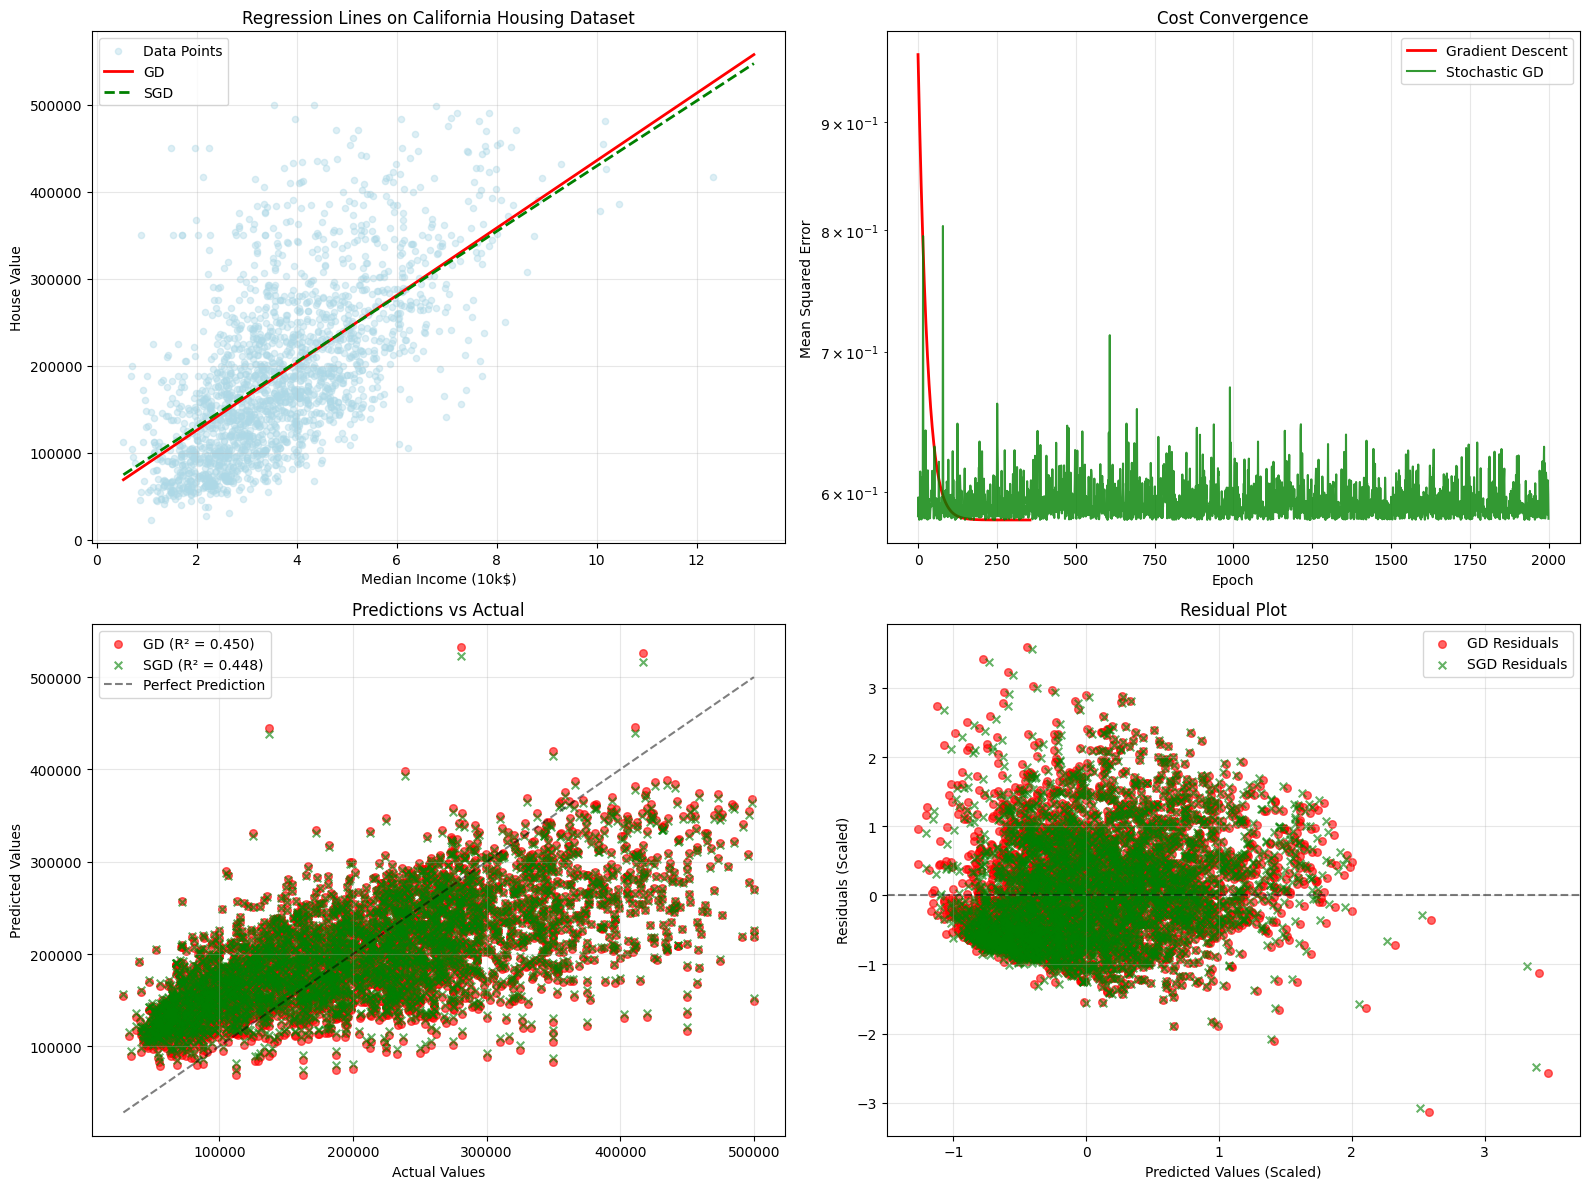

In [10]:
# --- 9. Data Visualization ---
import numpy as np
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
sample_indices = np.random.choice(len(X_raw), min(2000, len(X_raw)), replace=False)
X_sample = X_raw[sample_indices]
y_sample = y_raw[sample_indices]
ax1.scatter(X_sample, y_sample, alpha=0.4, color='lightblue', s=20, label='Data Points')
X_range = np.linspace(min(X_raw), max(X_raw), 100)
y_gd_range = gd_m_orig * X_range + gd_c_orig
y_sgd_range = sgd_m_orig * X_range + sgd_c_orig
ax1.plot(X_range, y_gd_range, color='red', linewidth=2, label=f'GD')
ax1.plot(X_range, y_sgd_range, color='green', linewidth=2, linestyle='--', label=f'SGD')
ax1.set_title(f'Regression Lines on {dataset_name}')
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.plot(gd_fitter.cost_history, color='red', label='Gradient Descent', linewidth=2)
ax2.plot(sgd_fitter.cost_history, color='green', label='Stochastic GD', alpha=0.8)
ax2.set_title('Cost Convergence')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax3.scatter(y_test * y_stats[1] + y_stats[0], X_test_pred_gd * y_stats[1] + y_stats[0],
            alpha=0.6, color='red', label=f'GD (R² = {gd_r2:.3f})', s=30)
ax3.scatter(y_test * y_stats[1] + y_stats[0], X_test_pred_sgd * y_stats[1] + y_stats[0],
            alpha=0.6, color='green', marker='x', label=f'SGD (R² = {sgd_r2:.3f})', s=30)
test_min = (y_test * y_stats[1] + y_stats[0]).min()
test_max = (y_test * y_stats[1] + y_stats[0]).max()
ax3.plot([test_min, test_max], [test_min, test_max], 'k--', alpha=0.5, label='Perfect Prediction')
ax3.set_title('Predictions vs Actual')
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted Values')
ax3.legend()
ax3.grid(True, alpha=0.3)
residuals_gd = y_test - X_test_pred_gd
residuals_sgd = y_test - X_test_pred_sgd
ax4.scatter(X_test_pred_gd, residuals_gd, alpha=0.6, color='red', label='GD Residuals', s=30)
ax4.scatter(X_test_pred_sgd, residuals_sgd, alpha=0.6, color='green', marker='x', label='SGD Residuals', s=30)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Residual Plot')
ax4.set_xlabel('Predicted Values (Scaled)')
ax4.set_ylabel('Residuals (Scaled)')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()